# atoti demonstration

### Key purpose of demonstration
- How to implement basic security 
    - Control on data level
    - Control on dashboard level
    - Control on application level
- Integration with MS SQL
- Creation of date hierarchy to provide aggregated summary on different date parts
- Real-time dataloading and dashboarding
- What-if with source simulation 

In [1]:
from datetime import date, datetime, timedelta

import atoti as tt
import polling
from util import mockML

## Security  

We will create the followings:
- roles with rules to access of data
- users with roles to apply control over type of acccess

Type of users:
- manager_fr
- manager_de
- market_manager_eu
- market_manager_us
- general_manager
- admin_user

https://docs.atoti.io/latest/lib/atoti-plus/atoti_plus.security.html#atoti_plus.security.Security

In [2]:
session = tt.create_session(
    "Sales",
    config={
        "user_content_storage": "./content",
        "authentication": {"basic": {"realm": "Test security"}},
        "port": 9090,
    },
)

In [3]:
session.security.create_role(
    "ROLE_EU_FR",
    restrictions={
        "HOSPITAL_ID": [
            "FR_HOSP_1",
            "FR_HOSP_2",
            "FR_HOSP_3",
            "FR_HOSP_4",
            "FR_HOSP_5",
            "FR_HOSP_6",
            "FR_HOSP_7",
            "FR_HOSP_8",
            "FR_HOSP_9",
            "FR_HOSP_10",
        ]
    },
)

session.security.create_role(
    "ROLE_EU_DE",
    restrictions={
        "HOSPITAL_ID": [
            "DE_HOSP_1",
            "DE_HOSP_2",
            "DE_HOSP_3",
            "DE_HOSP_4",
            "DE_HOSP_5",
            "DE_HOSP_6",
            "DE_HOSP_7",
            "DE_HOSP_8",
            "DE_HOSP_9",
            "DE_HOSP_10",
        ]
    },
)

session.security.create_role(
    "ROLE_MARKET_EU", restrictions={"COUNTRY": ["FRANCE", "GERMANY"]}
)

session.security.create_role("ROLE_MARKET_US", restrictions={"COUNTRY": ["USA"]})

Role(name='ROLE_MARKET_US', restrictions=Restrictions())

In [4]:
session.security.basic.create_user(
    "admin_user", password="admin_password", roles=["ROLE_ADMIN", "ROLE_SHARE"]
)

User(username='admin_user', roles=UserRoles(), _type='BASIC')

In [5]:
session.security.basic.create_user(
    "manager_fr", password="m1_password", roles=["ROLE_EU_FR"]
)

session.security.basic.create_user(
    "manager_de", password="m2_password", roles=["ROLE_EU_DE"]
)

session.security.basic.create_user(
    "market_manager_eu", password="eu_password", roles=["ROLE_MARKET_EU", "ROLE_SHARE"],
)

session.security.basic.create_user(
    "market_manager_us", password="us_password", roles=["ROLE_MARKET_US", "ROLE_SHARE"]
)

session.security.basic.create_user(
    "general_manager", password="gm_password", roles=["ROLE_USER", "ROLE_SHARE"]
)

User(username='general_manager', roles=UserRoles(), _type='BASIC')

In [6]:
session.security.basic.users.items()

dict_items([('manager_fr', User(username='manager_fr', roles=UserRoles(), _type='BASIC')), ('general_manager', User(username='general_manager', roles=UserRoles(), _type='BASIC')), ('manager_de', User(username='manager_de', roles=UserRoles(), _type='BASIC')), ('market_manager_us', User(username='market_manager_us', roles=UserRoles(), _type='BASIC')), ('market_manager_eu', User(username='market_manager_eu', roles=UserRoles(), _type='BASIC')), ('admin_user', User(username='admin_user', roles=UserRoles(), _type='BASIC'))])

## Read data from MS SQL

In [7]:
# to keep track of last polling time
last_poll_time = datetime.today()

sales_table = session.read_sql(
    """SELECT [DEPARTMENT], [QTY], [EQUIPMENT_ID], [UNIT_COST], [SALE_ID],
    CONVERT(DATE, [SALE_DATE]) as SALE_DATE, [HOSPITAL_ID], [LAST_UPDATE_DATE] 
    FROM [atoti].[atoti].[medical_sales]""",
    url="jdbc:sqlserver://localhost:1433;databaseName=atoti;user=atoti;password=atoti2",
    table_name="Sales",
    keys=["SALE_ID", "SALE_DATE", "EQUIPMENT_ID"],
)

In [8]:
sales_table.head()

DEPARTMENT  QTY  UNIT_COST  \
SALE_DATE  SALE_ID    EQUIPMENT_ID                                         
2021-04-01 M000000001 E0133                     EYE UNIT    2     144.93   
                      E0038                       MCH/FP    2     333.06   
                      E0285         OCCUPATIONAL THERAPY    1       6.34   
                      E0060                   DENTAL LAB    3      22.64   
                      E0107                          ENT    1      67.93   

                                   HOSPITAL_ID        LAST_UPDATE_DATE  
SALE_DATE  SALE_ID    EQUIPMENT_ID                                      
2021-04-01 M000000001 E0133          US_HOSP_1 2021-04-01 11:43:43.677  
                      E0038          US_HOSP_1 2021-04-01 11:43:43.677  
                      E0285          US_HOSP_1 2021-04-01 11:43:43.677  
                      E0060          US_HOSP_1 2021-04-01 11:43:43.677  
                      E0107          US_HOSP_1 2021-04-01 11:43:43.677

In [9]:
print(
    f"number of rows: {len(sales_table)}, number of columns: {len(sales_table.columns)}"
)

number of rows: 26988, number of columns: 8


In [10]:
sales_table

Table(_name='Sales', _scenario='Base', _columns={'DEPARTMENT': Column(name='DEPARTMENT', data_type=DataType(java_type='string', nullable=False)), 'QTY': Column(name='QTY', data_type=DataType(java_type='long', nullable=True)), 'EQUIPMENT_ID': Column(name='EQUIPMENT_ID', data_type=DataType(java_type='string', nullable=False)), 'UNIT_COST': Column(name='UNIT_COST', data_type=DataType(java_type='double', nullable=True)), 'SALE_ID': Column(name='SALE_ID', data_type=DataType(java_type='string', nullable=False)), 'SALE_DATE': Column(name='SALE_DATE', data_type=DataType(java_type='LocalDate', nullable=False)), 'HOSPITAL_ID': Column(name='HOSPITAL_ID', data_type=DataType(java_type='string', nullable=False)), 'LAST_UPDATE_DATE': Column(name='LAST_UPDATE_DATE', data_type=DataType(java_type='LocalDateTime', nullable=False))})

In [11]:
cube = session.create_cube(sales_table, "sales cube")

In [12]:
session.visualize("Equipment sales for 2021-09-22")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [13]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [14]:
m["Unit Cost"] = tt.value(sales_table["UNIT_COST"])

In [15]:
m["Sales amount"] = tt.agg.sum(
    m["QTY.SUM"] * m["Unit Cost"],
    scope=tt.scope.origin(l["EQUIPMENT_ID"], l["SALE_ID"], l["DEPARTMENT"]),
)

In [16]:
session.visualize("Sales amount for 2021-09-22")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Creating date parts (M, Y, d) 
https://docs.atoti.io/latest/lib/atoti.experimental.html#atoti.experimental.create_date_hierarchy

In [17]:
tt.experimental.create_date_hierarchy(
    "Quarterly",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Quarter": "QQQ", "Month": "MM"},
)

In [18]:
tt.experimental.create_date_hierarchy(
    "Weekly",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Month": "MM", "Week": "w", "Week Dtl": "(Y-MM) W"},
)

In [19]:
tt.experimental.create_date_hierarchy(
    "Date parts",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Month": "MM", "Day": "dd"},
)

In [20]:
tt.experimental.create_date_hierarchy(
    "Year to Date",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Date": "Y-MM-dd"},
)

In [21]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Loading product and shop details

In [22]:
device_table = session.read_sql(
    "SELECT * FROM [atoti].[atoti].[devices];",
    url="jdbc:sqlserver://localhost:1433;databaseName=atoti;user=atoti;password=atoti2",
    table_name="Devices",
    keys=["EQUIPMENT_ID"],
)

In [23]:
device_table.head()

,EQUIPMENT,PURCHASE_PRICE
EQUIPMENT_ID,,
E0004,Chest tubes,4.31
E0000,Thermometer clinical,1.01
E0001,"Intubation tubes, assorted sizes",2.50
E0002,Pedal Pins,2.88
E0003,Stethoscope,4.52


In [24]:
hospital_table = session.read_sql(
    "SELECT * FROM [atoti].[atoti].[hospitals];",
    url="jdbc:sqlserver://localhost:1433;databaseName=atoti;user=atoti;password=atoti2",
    table_name="Hospital",
    keys=["HOSPITAL_ID"],
)

In [25]:
hospital_table.head()

,COUNTRY,CITY
HOSPITAL_ID,,
US_HOSP_1,USA,NEW YORK
US_HOSP_2,USA,NEW YORK
US_HOSP_4,USA,NEW YORK
US_HOSP_5,USA,LOS ANGELES
US_HOSP_6,USA,LOS ANGELES


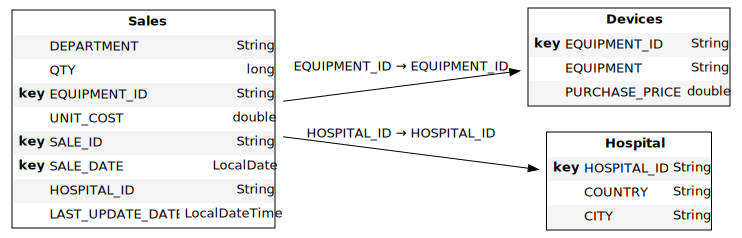

In [26]:
sales_table.join(device_table)
sales_table.join(hospital_table)
cube.schema

In [27]:
h["LOCATION"] = [l["COUNTRY"], l["CITY"]]

In [28]:
session.visualize("Sales amount by location")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [29]:
session.visualize("Sales per equipment by country")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Sample measures creation

In [30]:
m["Purchase price"] = tt.value(
    device_table["PURCHASE_PRICE"], levels=[l["EQUIPMENT"], l["EQUIPMENT_ID"]]
)

In [31]:
m["Cost price"] = tt.agg.sum(
    m["QTY.SUM"] * m["Purchase price"],
    scope=tt.scope.origin(l["EQUIPMENT_ID"], l["SALE_ID"], l["DEPARTMENT"]),
)

In [32]:
m["Margin"] = m["Sales amount"] - m["Cost price"]

In [33]:
m["Margin rate"] = m["Margin"] / m["Sales amount"]
# m["Margin rate"].formatter = "DOUBLE[0.000%]"

In [34]:
m["Hospital count"] = tt.agg.count_distinct(hospital_table["HOSPITAL_ID"])

In [35]:
m["Quarterly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["Quarter"])
)

m["Monthly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(cube.levels[("Sales", "Quarterly", "Month")])
)

m["Weekly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["Week Dtl"])
)

m["Daily cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["SALE_DATE"])
)

In [36]:
m["Quarterly cumulative margin"].folder = "Cumulative"
m["Monthly cumulative margin"].folder = "Cumulative"
m["Weekly cumulative margin"].folder = "Cumulative"
m["Daily cumulative margin"].folder = "Cumulative"

In [37]:
session.visualize("Sales trend")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [38]:
session.visualize("Sales trend")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Computing YTD and YTM with cumulative scope

In [51]:
m["YTD"] = tt.agg.sum(m["Margin"], scope=tt.scope.cumulative(l["Day"], partitioning=cube.levels[("Sales", "Date parts", "Year")]))

In [53]:
m["YTM"] = tt.agg.sum(m["Margin"], scope=tt.scope.cumulative(cube.levels[("Sales", "Date parts", "Month")], partitioning=cube.levels[("Sales", "Date parts", "Year")]))

In [54]:
session.visualize("YTD - YTM")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Accessing web application

In [39]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Real-time polling of delta data

In [40]:
poll_interval = 5
# start_time = datetime.today()


def poll_db(duration):
    global last_poll_time, start_time

    current_time = datetime.today()
    #     # buffered some additional time interval to ensure we covered the boundary
    #     last_poll_time = current_time - timedelta(seconds=(poll_interval*2))

    print(
        f"current_time: {current_time}, last_poll_time {last_poll_time}, lapsed: {(current_time - start_time).total_seconds()}"
    )
    # just to stop polling after duration
    if (current_time - start_time).total_seconds() > duration:
        print(
            f"Duration over. Polling stopped. Last polling time: {last_poll_time}, Current time: {current_time}"
        )
        return False
    else:
        sales_table.load_sql(
            f"SELECT [DEPARTMENT], [QTY], [EQUIPMENT_ID], [UNIT_COST], [SALE_ID], CONVERT(DATE, [SALE_DATE]) as SALE_DATE, [HOSPITAL_ID], [LAST_UPDATE_DATE] FROM [atoti].[atoti].[medical_sales] WHERE [LAST_UPDATE_DATE] >= Convert(datetime, '{last_poll_time.strftime('%Y-%m-%d %H:%M:%S')}');",
            url="jdbc:sqlserver://localhost:1433;databaseName=atoti;user=atoti;password=atoti2",
        )
        # buffered some additional time interval to ensure we covered the boundary
        last_poll_time = current_time - timedelta(seconds=poll_interval)

        return True

In [41]:
## Uncomment the below to perform polling of db
# start_time = datetime.today()
# polling.poll(lambda: poll_db(150) == False, step=poll_interval, poll_forever=True)

Refer to the "Country sales" tab of the below dashboard for real-time analytics.

In [49]:
session.link(path="/#/dashboard/f81")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Source Simulation

In [42]:
sales_qty = cube.query(
    m["QTY.SUM"],
    m["Unit Cost"],
    levels=[
        l["HOSPITAL_ID"],
        l["DEPARTMENT"],
        l["EQUIPMENT"],
        l["EQUIPMENT_ID"],
        l["SALE_ID"],
        l["SALE_DATE"],
    ],
    condition=(h["Quarterly"].isin(("2021", "Q3"))),
)

In [43]:
sales_qty.reset_index(inplace=True)
sales_qty.head()

,HOSPITAL_ID,DEPARTMENT,EQUIPMENT,EQUIPMENT_ID,SALE_ID,SALE_DATE,QTY.SUM,Unit Cost
0,DE_HOSP_1,CASUALTY,"Ambu bag, adult",E0016,M000002603,2021-08-31,3,31.70
1,DE_HOSP_1,CASUALTY,Diagnostic set,E0025,M000002288,2021-08-13,2,59.78
2,DE_HOSP_1,CASUALTY,Diagnostic set,E0025,M000002774,2021-09-10,2,59.78
3,DE_HOSP_1,CASUALTY,ECG Monitor,E0044,M000002551,2021-08-27,1,6723.52
4,DE_HOSP_1,CASUALTY,Emergency lamp,E0034,M000002176,2021-08-07,1,13.59


In [44]:
from util import mockML

In [45]:
predicted_sales = mockML.predict_prod_sales(sales_qty, 3)
predicted_sales.head()

,HOSPITAL_ID,EQUIPMENT_ID,DEPARTMENT,UNIT_COST,QTY,SALE_ID,SALE_DATE,LAST_UPDATE_DATE
0,DE_HOSP_1,E0000,OUT PATIENT DEPARTMENT,1.36,3.0,Forecast_DE_HOSP_1_20211012,2021-10-12,2021-10-11 10:53:45
2,DE_HOSP_1,E0002,CASUALTY,4.08,2.0,Forecast_DE_HOSP_1_20211012,2021-10-12,2021-10-11 10:53:45
3,DE_HOSP_1,E0003,CASUALTY,5.43,1.0,Forecast_DE_HOSP_1_20211012,2021-10-12,2021-10-11 10:53:45
5,DE_HOSP_1,E0003,MCH/FP,5.43,1.0,Forecast_DE_HOSP_1_20211012,2021-10-12,2021-10-11 10:53:45
6,DE_HOSP_1,E0003,MINOR THEATRE,5.43,1.0,Forecast_DE_HOSP_1_20211012,2021-10-12,2021-10-11 10:53:45


In [46]:
sales_table.scenarios["Demand forecast"].drop()
sales_table.scenarios["Demand forecast"].load_pandas(predicted_sales)

In [47]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [48]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.